## MAP estimation with Pyro

In [1]:
import torch
import pyro
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
from collections import Counter
import pyro.distributions as dist
from pyro.infer import Predictive, SVI, Trace_ELBO, NUTS, MCMC
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam

pyro.enable_validation(True)
pyro.set_rng_seed(101)


### Beta Bernoulli model
We will use a model that has closed solution of the posterior distribution
to demonstrate how we can find the maximum a posterior (MAP) estimate with
Pyro.

Lets simulate some data points from a Bernoulli, this will be
our real data.

In [2]:
n_data_points = 15
real_p = torch.tensor(0.1)
real_dist = torch.distributions.Bernoulli(real_p)
simulated_data = real_dist.sample((n_data_points,))
print(simulated_data)

tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.])


Assuming a Beta Bernoulli model the posterior distribution is the following:
$$Beta(\alpha + number \; of \; ones, \beta + number \; of \; zeros)$$

You can check the theory [here](https://en.wikipedia.org/wiki/Conjugate_prior#Example)

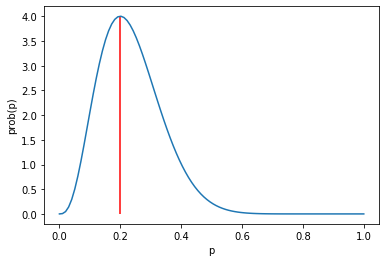

In [3]:
counts = Counter(simulated_data.numpy())
# Beta(1 + #1s, 1 + #0s)
beta_dist = stats.beta(1 + counts[1], 1 + counts[0])
fig, ax = plt.subplots(1, 1)
ps = np.linspace(0, 1, 100)
ax.plot(ps, beta_dist.pdf(ps))
ax.set_xlabel('p')
ax.set_ylabel('prob(p)')
ax.vlines(0.2, 0, 4, colors='r');

Given our model and the observed data, we see that the posterior distributiom 
peeks around 0.2 (the real value is 0.1). 
However for most of the problems is not easy to find the
posterior distribution. This is why tools like Pyro or PyMC3(or PyMC4) were developed 
to help us estimate it.

Lets define the model in Pyro

In [4]:
def model(data: torch.Tensor) -> torch.Tensor:
    alpha = torch.tensor(1.)
    beta = torch.tensor(1.)
    p = pyro.sample('p', dist.Beta(alpha, beta))
    with pyro.plate('iid_obs', len(data)):
        obs = pyro.sample('obs', dist.Bernoulli(p), obs=data)
    return p


The  easiest way that I've found to estimate the MAP is through the
AutoDelta guide. Using stochastic variational inference we can find the
peek of the posterior distribution with following code.

In [5]:
guide = AutoDelta(model)
# Optimizer
adam_params = {"lr": 0.005, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)
# inference objects
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# gradient steps
n_steps = 1000
for step in tqdm(range(n_steps), total=n_steps):
    svi.step(simulated_data)

100%|██████████| 1000/1000 [00:02<00:00, 469.67it/s]


If we sample from the adjusted distribution we will see that all the
returned values corresponds to MAP point.

In [6]:
predictive = Predictive(
    model=model , guide=guide,
    num_samples=10, parallel=True
)
samples = predictive(simulated_data)
samples = {
    k: v.detach().numpy().flatten()
    for k, v in samples.items()
}
samples['p']

array([0.20066166, 0.20066166, 0.20066166, 0.20066166, 0.20066166,
       0.20066166, 0.20066166, 0.20066166, 0.20066166, 0.20066166],
      dtype=float32)

Nevertheless, I prefer to estimate the full posterior distribution when
the amount of data is limited because I can get a better picture of the
uncertainty around my estimation. And for this model is easy to
do it with MCMC.

In [7]:
nuts_kernel = NUTS(model, jit_compile=False)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(simulated_data)
samples = {
    k: v.detach().numpy()
    for k, v in mcmc.get_samples().items()
}

Sample: 100%|██████████| 1200/1200 [00:05, 235.19it/s, step size=1.43e+00, acc. prob=0.894]


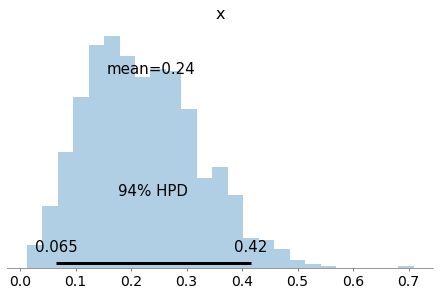

In [8]:
ax = az.plot_posterior(samples['p'], kind='hist');
plt.show()

### Bonus: find the MAP point using scipy optimize and other Pyro functionalities

With Pyro we can get the log probability of a model easily using the
trace object, what we can do is condition our previous model on a specific
value of __p__ in order to find which values returns the lowest negative 
log probability value (which is the point with the highest pdf)

In [9]:
from scipy import optimize


def map_loss(p: float) -> float:
    p = torch.tensor(float(p))
    cond_model = pyro.condition(model, data={'p': p})
    trace_handler = pyro.poutine.trace(cond_model)
    trace = trace_handler.get_trace(simulated_data)
    log_prob_sum = trace.log_prob_sum()
    neg_log_prob = -log_prob_sum
    return float(neg_log_prob.item())

map_loss(0.5)

10.397209167480469

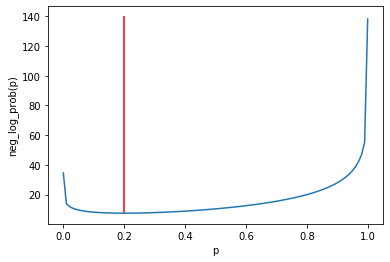

In [13]:
fig, ax = plt.subplots(1, 1)
# we will not use 0, 1 as the limits beacuase  
# given the data those points might not be feasiable
bounds = (0.00001, 0.99999)
ps = np.linspace(bounds[0], bounds[1], 100)
loss_values = np.array([map_loss(p) for p in ps])
ax.plot(ps, loss_values)
ax.vlines(0.2, 7, 140, colors='r')
ax.set_xlabel('p')
ax.set_ylabel('neg_log_prob(p)')
plt.show()


In [11]:
result = optimize.minimize_scalar(
    map_loss, bounds=bounds, method='bounded'
)
result

     fun: 7.506034851074219
 message: 'Solution found.'
    nfev: 14
  status: 0
 success: True
       x: 0.2000077794371028

The resulting value of the optimization is the same as the one found by the AutoDelta guide.
However I do not recommend using this method since it can be slower and you have to define 
more steps according to your problem.

